# python 에 필요한 module 불러오기

In [161]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from math import exp

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import FinanceDataReader as fdr
from sklearn.metrics import accuracy_score

# 특성(MA,Stochastic,rsi) 추가

In [162]:


#특성 추가 ------------------------------------------
    #이동평균선
def get_MA(df):
    MA_26=df["Close"].rolling(26).mean()
    MA_52=df["Close"].rolling(52).mean()
    df=df.assign(MA_26=MA_26,MA_52=MA_52).dropna()
    
    return df

    
    #스토캐스틱
def get_stochastic(df, n=15, m=5, t=3):
    # n일중 최고가
    ndays_high = df.High.rolling(window=n, min_periods=1).max()
    # n일중 최저가
    ndays_low = df.Low.rolling(window=n, min_periods=1).min()
 
    # Fast%K 계산
    kdj_k = ((df.Close - ndays_low) / (ndays_high - ndays_low))*100
    # Fast%D (=Slow%K) 계산
    kdj_d = kdj_k.ewm(span=m).mean()
    # Slow%D 계산
    kdj_j = kdj_d.ewm(span=t).mean()
 
    # dataframe에 컬럼 추가
    df = df.assign(kdj_k=kdj_k, kdj_d=kdj_d, kdj_j=kdj_j).dropna()
    
    return df


def rsi(values):
    up = values[values>0].mean()
    down = -1*values[values<0].mean()
    return 100 * up / (up + down)
# Add Momentum_1D column for all 15 stocks.
# Momentum_1D = P(t) - P(t-1)


# 주식 데이터 불러오기

In [163]:
KS11 = fdr.DataReader("KS11","2009-01-01","2019-01-01") #코스피
KQ11= fdr.DataReader("KQ11","2009-01-01","2019-01-01") #코스닥
US500 = fdr.DataReader("US500","2009-01-01","2019-01-01") #SP500
HSI = fdr.DataReader("HSI","2009-01-01","2019-01-01") #항생지수
IXIC = fdr.DataReader("IXIC","2009-01-01","2019-01-01") #나스닥

KS11 = KS11.drop(['Volume'], axis = 1 )
KQ11 = KQ11.drop(['Volume'], axis = 1 )
US500 = US500.drop(['Volume'], axis = 1 )
HSI = HSI.drop(['Volume'], axis = 1 )
IXIC = IXIC.drop(['Volume'], axis = 1 )

# 사용될 변수 생성

In [164]:
예측dic={}
수익률dic={}
EndSwitch = 1 # 0이 되면 반복 종료
초기돈 = 10000
d,dd= 1, 20
BATCH = 20 # 리밸런싱 주기
count = 0 # 리밸런싱된 횟수 count
pred_dic={}
투자결과=[]

all_df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"]) # 총 table
set_df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"]) # 20일 주기 table

# Main 모델

In [168]:

for 인덱스,인덱스명 in zip([KS11,KQ11,IXIC,HSI,US500],["코스피","코스닥","나스닥","항생","S&P500"]):
    df = 인덱스
    
    # 특성 추가--------------------------------------------------------
    
    
        #스토캐스틱과 이동평균선
    df=get_stochastic(df)
    df=get_MA(df)
    
        #RSI
    df['Momentum_1D'] = (df['Close']-df['Close'].shift(1))
    df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi)
    df=df.dropna()
    df=df[0:-(len(df)%BATCH)]
    df = df.drop(labels = ['Momentum_1D'], axis=1)
    
        #이동평균선
    MA_26=df["Close"].rolling(21).mean()
    df_MA=MA_26.dropna()
    df_char=df[20:] # df_char : 특성 모두 추가한 data, rolling,shifting 고려해서 제거
       #------------------------------------------------------------------
    
    
    
    
        # y ( target ) 생성 df_char= 값, df_MA= 이동평균선---------------------
    y=[]
    #20개로 1개 예측
    h=1
    for x in range(1,len(df_char)+1):
        if(df_char["Close"][x-1] > df_MA[20*h-1]):
            y.append(0)
        else:
            y.append(1)
        if(x%20==0):
            h=h+1

    df = df_char[:-20] # 20개 1개 예측이면 :-20, 20개로 20개예측이면 -20 제거
    nparr = df # 스케일링 할 데이터
    nparr2 = df # 스케일링 안한 데이터 백업

    #normalizing
    scaler = MinMaxScaler(feature_range=(0, 1))
    df["Close"]=scaler.fit_transform(nparr["Close"].values.reshape(-1,1))
    df["Open"]=scaler.fit_transform(nparr["Open"].values.reshape(-1,1))
    df["High"]=scaler.fit_transform(nparr["High"].values.reshape(-1,1))
    df["Low"]=scaler.fit_transform(nparr["Low"].values.reshape(-1,1))
    df["Change"]=scaler.fit_transform(nparr["Change"].values.reshape(-1,1))
    df["kdj_k"]=scaler.fit_transform(nparr["kdj_k"].values.reshape(-1,1))
    df["kdj_d"]=scaler.fit_transform(nparr["kdj_d"].values.reshape(-1,1))
    df["kdj_j"]=scaler.fit_transform(nparr["kdj_j"].values.reshape(-1,1))
    df["MA_26"]=scaler.fit_transform(nparr["MA_26"].values.reshape(-1,1))
    df["MA_52"]=scaler.fit_transform(nparr["MA_52"].values.reshape(-1,1))
    df["RSI_14D"]=scaler.fit_transform(nparr["RSI_14D"].values.reshape(-1,1))
    
    #-----
    #df["y"]=y
    #print(df.corr()) #상관관계 분석 ( 출력하고 싶다면 주석 제거)
    #df = df.drop(['y'],axis = 1)
    #-----
    
    df = df.drop(['Close','Open','High','Low','MA_26','MA_52'], axis = 1 ) # 상관관계 분석 후 관계 적은 특성(열) 제거
    X=df.values
    
    # train test val 세팅
    setlen=int(len(X)/20*0.7)*20 # 데이터를 7:3으로 나누고 20의 배수로 만듬
    X_train=X[:setlen]
    X_test=X[setlen:]
    y_train=y[:setlen]
    y_test=y[setlen:]
    
    setlen2=int(len(X_train)/20*0.3)*20 # 검증 데이터를 3:7으로 나누고 20의 배수로 만듬
    X_val = X_train[ : setlen2]
    y_val = y_train[ : setlen2]
    X_train2 = X_train[setlen2 : ]
    y_train2 = y_train[setlen2 : ]
    
    
    # 딥러닝 모델에 맞는 사이즈로 전처리
    X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))
    
    X_val = np.reshape(X_val, (X_val.shape[0],1, X_val.shape[1]))
    X_train2 = np.reshape(X_train2, (X_train2.shape[0],1, X_train2.shape[1]))
    
    #LSTM모델 생성
    model = Sequential()
    model.add(LSTM(36, input_shape=(1, 5)))
    for i in range(2):
        model.add(Dense(18,activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train2, y_train2, epochs=6, batch_size=16,validation_data=(X_val,y_val),verbose=0)
    
    history_dict= history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['accuracy']
    epochs = range(1,len(acc)+1)

    plt.plot(epochs,loss_values,'bo',label='Training loss')
    plt.plot(epochs,val_loss_values,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    pred=np.where(model.predict(X_test)>0.5,1,0)
    예측dic[인덱스명]=pred # 예측 데이터 table에 추가
    수익률dic[인덱스명]=nparr2["Close"][setlen:] #투자 결과를 보기 위해 실제 수익률을 구함

    print(인덱스명, "정확도 : ", accuracy_score(y_test,np.where(model.predict(X_test)>0.5,1,0)))
       
    #모델 생성 완료 ------------------------------


End=1
while End==1: # 종료조건 ( END =0 )까지 반복
    
    # 날짜 출력 ------   
    day= str(d) +"~" + str(dd) + "일 차"
    print(day,"---------------------------------")
    # --------------- 
    set_df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])

    
    
    for key,val in zip(예측dic.keys(),예측dic.values()): 
    
    
        #----------------------- 지수함수로 중요 비중 조정
        e_sum = 0
        for xx in range(1,21):
            e_sum=e_sum+exp(xx)

        pred_list=[]
        rank=1
        pred=val[BATCH-20:BATCH] # BATCH는 0부터 매 리밸런싱마다 20씩 증가
        
        for yy in pred:
            pred_list.append(yy*rank)
            rank = rank + 1       # ex ) [1,1,1,0,1,0,..] -> [1,2,3,0,5,0..] 로 가중치를 줌


        pred_sum=0
        for zz in pred_list:
            pred_sum=pred_sum+(exp(zz)/e_sum) # 가중치를 e에 대입
        pred_sum=round(pred_sum,4) # 소수 4번째 반올림
        #--------------------------------------------------
        
        
        # 예측 결과를 표(dataframe)로 보기 쉽게 정리-----------------
        if count==0:
            pred_dic[key]=pred_sum #pred_dic == {}
        else:
            pred_dic[key]=np.append(pred_dic[key],pred_sum)
        예측 = pred_sum
        실제수익률 = ((수익률dic[key][BATCH+19])/(수익률dic[key][BATCH]))-1
        turn_df=pd.DataFrame(data={"영업일":[day],"인덱스":[key],"상승예측확률":[예측],"실제수익률":[실제수익률] }, columns=["영업일","인덱스","상승예측확률","실제수익률"])
        set_df=pd.concat([set_df,turn_df])    
        #------------------------------------------------------------
        
    #--------데이터 20개 중 60% 이상 상승 예측 시 list에 추가
    earn_list=[]
    
    for x,y in zip(set_df["상승예측확률"],set_df["실제수익률"]):
        
        if x>=0.6:
            earn_list.append(y)
    
    #-------하나도 상승 예측이 아니었다면 규제 줄이기
    if len(earn_list)==0:
        for x,y in zip(set_df["상승예측확률"],set_df["실제수익률"]):
        
            if x>=0.4:
                earn_list.append(y)
    #---------------------------------------------------------------------
    
    
    earn_list2=[]
    if len(earn_list)!=0:
        초기돈=초기돈/(len(earn_list))
        for y in earn_list:
            earn_list2.append(초기돈+(초기돈*y))
        초기돈=sum(earn_list2)    
    else:
        earn_list2.append(초기돈)
    

    all_df=pd.concat([all_df,set_df])
    BATCH=BATCH+20

    print("분산 투자 : ",earn_list2)
    print("투자 결과 : ",초기돈)
    print(set_df.head(5))
    count=count+1
    d=d+20
    dd=dd+20

        #종료조건---------------

    if(len(수익률dic[key])==BATCH+20):
        End=0
        print("------------종료------------  ◆리밸런싱 수◆ : " , count)
        break
        #----------------------------------

ValueError: Initializer for variable lstm_89/bias/ is from inside a control-flow construct, such as a loop or conditional. When creating a variable inside a loop or conditional, use a lambda as the initializer.

In [166]:
X_train.shape

(1640, 1, 5)

In [148]:

for 인덱스,인덱스명 in zip([KS11,KQ11,IXIC,HSI,US500],["코스피","코스닥","나스닥","항생","S&P500"]):
    df = 인덱스
    
    # 특성 추가--------------------------------------------------------
    
    
        #스토캐스틱과 이동평균선
    df=get_stochastic(df)
    df=get_MA(df)
    
        #RSI
    df['Momentum_1D'] = (df['Close']-df['Close'].shift(1))
    df['RSI_14D'] = df['Momentum_1D'].rolling(center=False, window=14).apply(rsi)
    df=df.dropna()
    df=df[0:-(len(df)%BATCH)]
    df = df.drop(labels = ['Momentum_1D'], axis=1)
    
        #이동평균선
    MA_26=df["Close"].rolling(21).mean()
    df_MA=MA_26.dropna()
    df_char=df[20:-20] # df_char : 특성 모두 추가한 data, rolling,shifting 고려해서 제거
       #------------------------------------------------------------------
    y=[]
    for x in range(0,len(df_char)):
        if(df_char["Close"][x] > df_MA[x+20]):
            y.append(1)
        else:
            y.append(0)

#     y=np.where(np.array(df_char["Close"])>np.array(df_MA.shift(-20).dropna()),1,0) #값과 이평선( 20일 차 )

    df = df_char[:] # 20개 1개 예측이면 :-20, 20개로 20개예측이면 -20 제거
    nparr = df # 스케일링 할 데이터
    nparr2 = df # 스케일링 안한 데이터 백업

    
    #normalizing
    scaler = MinMaxScaler(feature_range=(0, 1))
    df["Close"]=scaler.fit_transform(nparr["Close"].values.reshape(-1,1))
    df["Open"]=scaler.fit_transform(nparr["Open"].values.reshape(-1,1))
    df["High"]=scaler.fit_transform(nparr["High"].values.reshape(-1,1))
    df["Low"]=scaler.fit_transform(nparr["Low"].values.reshape(-1,1))
    df["Change"]=scaler.fit_transform(nparr["Change"].values.reshape(-1,1))
    df["kdj_k"]=scaler.fit_transform(nparr["kdj_k"].values.reshape(-1,1))
    df["kdj_d"]=scaler.fit_transform(nparr["kdj_d"].values.reshape(-1,1))
    df["kdj_j"]=scaler.fit_transform(nparr["kdj_j"].values.reshape(-1,1))
    df["MA_26"]=scaler.fit_transform(nparr["MA_26"].values.reshape(-1,1))
    df["MA_52"]=scaler.fit_transform(nparr["MA_52"].values.reshape(-1,1))
    df["RSI_14D"]=scaler.fit_transform(nparr["RSI_14D"].values.reshape(-1,1))
    
    #-----
#     df["y"]=y
#     print(df.corr()) #상관관계 분석 ( 출력하고 싶다면 주석 제거)
#     df = df.drop(['y'],axis = 1)
    #-----
    
    df = df.drop(['Close','Open','High','Low','MA_26','MA_52'], axis = 1 ) # 상관관계 분석 후 관계 적은 특성(열) 제거
    X=df.values
    
    # train test val 세팅
    setlen=int(len(X)/20*0.7)*20 # 데이터를 7:3으로 나누고 20의 배수로 만듬
    X_train=X[:setlen]
    X_test=X[setlen:]
    y_train=y[:setlen]
    y_test=y[setlen:]
    
    setlen2=int(len(X_train)/20*0.3)*20 # 검증 데이터를 3:7으로 나누고 20의 배수로 만듬
    X_val = X_train[ : setlen2]
    y_val = y_train[ : setlen2]
    X_train2 = X_train[setlen2 : ]
    y_train2 = y_train[setlen2 : ]
    
    
    # 딥러닝 모델에 맞는 사이즈로 전처리
    X_train = np.reshape(X_train, (X_train.shape[0],1, X_train.shape[1]))
    X_test = np.reshape(X_test, (X_test.shape[0],1, X_test.shape[1]))
    
    X_val = np.reshape(X_val, (X_val.shape[0],1, X_val.shape[1]))
    X_train2 = np.reshape(X_train2, (X_train2.shape[0],1, X_train2.shape[1]))
    
    #LSTM모델 생성
    model = Sequential()
    model.add(LSTM(36, input_shape=(1, 5)))
    for i in range(2):
        model.add(Dense(18,activation='relu'))
        model.add(Dropout(0.2))
    model.add(Dense(1,activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(X_train2, y_train2, epochs=6, batch_size=16,validation_data=(X_val,y_val),verbose=0)
    
    history_dict= history.history
    loss_values = history_dict['loss']
    val_loss_values = history_dict['val_loss']
    acc = history_dict['accuracy']
    epochs = range(1,len(acc)+1)

    plt.plot(epochs,loss_values,'bo',label='Training loss')
    plt.plot(epochs,val_loss_values,'b',label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    pred=np.where(model.predict(X_test)>0.5,1,0)
    예측dic[인덱스명]=pred # 예측 데이터 table에 추가
    수익률dic[인덱스명]=nparr2["Close"][setlen:] #투자 결과를 보기 위해 실제 수익률을 구함

    print(인덱스명, "정확도 : ", accuracy_score(y_test,np.where(model.predict(X_test)>0.5,1,0)))
       
    #모델 생성 완료 ------------------------------


End=1
while End==1: # 종료조건 ( END =0 )까지 반복
    
    # 날짜 출력 ------   
    day= str(d) +"~" + str(dd) + "일 차"
    print(day,"---------------------------------")
    # --------------- 
    set_df=pd.DataFrame(columns=["영업일","인덱스","상승예측확률","실제수익률"])

    
    
    for key,val in zip(예측dic.keys(),예측dic.values()): 
    
    
        # 비중조정없음--
        pred=val[BATCH-20:BATCH]
        pred_sum=sum(pred)
        #--------------------------------------------------
        
        
        # 예측 결과를 표(dataframe)로 보기 쉽게 정리-----------------
        if count==0:
            pred_dic[key]=pred_sum #pred_dic == {}
        else:
            pred_dic[key]=np.append(pred_dic[key],pred_sum)
        예측 = pred_sum/20
        실제수익률 = ((수익률dic[key][BATCH+19])/(수익률dic[key][BATCH]))-1
        turn_df=pd.DataFrame(data={"영업일":[day],"인덱스":[key],"상승예측확률":[예측],"실제수익률":[실제수익률] }, columns=["영업일","인덱스","상승예측확률","실제수익률"])
        set_df=pd.concat([set_df,turn_df])    
        #------------------------------------------------------------
        
    #--------데이터 20개 중 60% 이상 상승 예측 시 list에 추가
    earn_list=[]
    
    for x,y in zip(set_df["상승예측확률"],set_df["실제수익률"]):
        
        if x>=0.6:
            earn_list.append(y)
    
    #-------하나도 상승 예측이 아니었다면 규제 줄이기
    if len(earn_list)==0:
        for x,y in zip(set_df["상승예측확률"],set_df["실제수익률"]):
        
            if x>=0.4:
                earn_list.append(y)
    #---------------------------------------------------------------------
    
    
    earn_list2=[]
    if len(earn_list)!=0:
        초기돈=초기돈/(len(earn_list))
        for y in earn_list:
            earn_list2.append(초기돈+(초기돈*y))
        초기돈=sum(earn_list2)    
    else:
        earn_list2.append(초기돈)
    

    all_df=pd.concat([all_df,set_df])
    BATCH=BATCH+20

    print("분산 투자 : ",earn_list2)
    print("투자 결과 : ",초기돈)
    print(set_df.head(5))
    count=count+1
    d=d+20
    dd=dd+20

        #종료조건---------------

    if(len(수익률dic[key])==BATCH+20):
        End=0
        print("------------종료------------  ◆리밸런싱 수◆ : " , count)
        break
        #----------------------------------

ValueError: Initializer for variable lstm_82/bias/ is from inside a control-flow construct, such as a loop or conditional. When creating a variable inside a loop or conditional, use a lambda as the initializer.

In [83]:
(ho_dic["코스피"]+ho_dic["코스닥"]+ho_dic["나스닥"]+ho_dic['항생']+ho_dic["S&P500"])/5

,Close,Open,High,Low,Change,kdj_k,kdj_d,kdj_j,MA_26,MA_52,RSI_14D,y
Close,1.000000,0.998715,0.999337,0.999494,0.015206,0.068068,0.077974,0.079723,0.984766,0.970942,0.072694,-0.090708
Open,0.998715,1.000000,0.999569,0.999204,-0.020894,0.051945,0.072280,0.077292,0.985684,0.971743,0.067324,-0.083135
High,0.999337,0.999569,1.000000,0.999167,-0.008152,0.053079,0.069327,0.073409,0.986543,0.972856,0.065906,-0.083113
Low,0.999494,0.999204,0.999167,1.000000,0.002420,0.066184,0.080376,0.083093,0.984043,0.970008,0.074089,-0.090376
Change,0.015206,-0.020894,-0.008152,0.002420,1.000000,0.415547,0.143374,0.057160,-0.035080,-0.033227,0.141130,-0.200830
kdj_k,0.068068,0.051945,0.053079,0.066184,0.415547,1.000000,0.899231,0.803273,-0.056700,-0.065149,0.494614,-0.496330
kdj_d,0.077974,0.072280,0.069327,0.080376,0.143374,0.899231,1.000000,0.980342,-0.053669,-0.071287,0.544340,-0.447462
kdj_j,0.079723,0.077292,0.073409,0.083093,0.057160,0.803273,0.980342,1.000000,-0.048850,-0.071116,0.540528,-0.399029
MA_26,0.984766,0.985684,0.986543,0.984043,-0.035080,-0.056700,-0.053669,-0.048850,1.000000,0.992477,-0.010909,-0.022565
MA_52,0.970942,0.971743,0.972856,0.970008,-0.033227,-0.065149,-0.071287,-0.071116,0.992477,1.000000,-0.028219,-0.015638


Text(0.5, 0, 'Day')

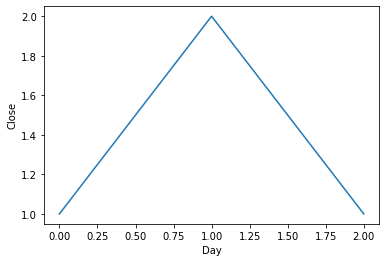

In [98]:
y=[1,2,1]

plt.plot(y)
plt.ylabel("Close")
plt.xlabel("Day")

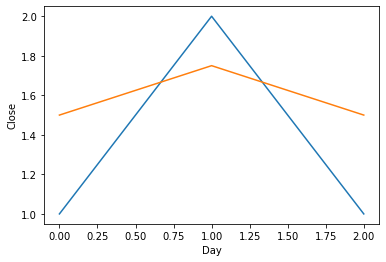

In [106]:
y=[1,2,1]
z=[1.5,1.75,1.5]
plt.plot(y)
plt.ylabel("Close")
plt.xlabel("Day")
plt.plot(z,'-')